Using files:
  listings.csv.gz 
  calendar.csv.gz 
  reviews.csv.gz
Listings shape: (15187, 79)


,price,price_clean
0,$101.00,101.0
1,$45.00,45.0
2,NaN,NaN
3,$155.00,155.0
4,$43.00,43.0


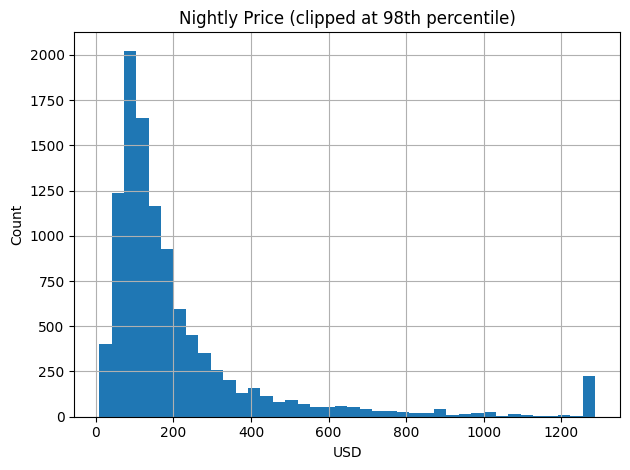

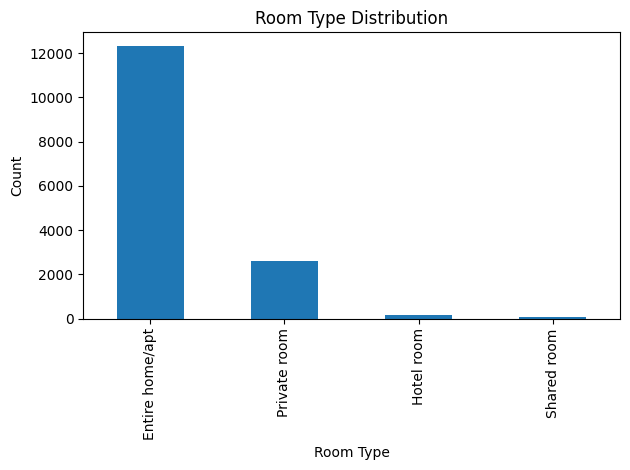

Saved sample to: ..\data\PROCESSED\listings_sample.csv


In [1]:
# --- 0) Imports & paths
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

RAW  = Path("../data/RAW")
PROC = Path("../data/PROCESSED")
FIGS = Path("../figures")
for p in [PROC, FIGS]: p.mkdir(parents=True, exist_ok=True)

# --- 1) Helper: find a file even if the exact name varies
def first_existing(*names):
    for n in names:
        p = RAW / n
        if p.exists():
            return p
    raise FileNotFoundError(f"None of these files were found in {RAW}:\n{names}")

LISTINGS = first_existing("listings.csv.gz", "listings.csv")
CAL      = first_existing("calendar.csv.gz", "calendar.csv")
REVIEWS  = first_existing("reviews.csv.gz", "reviews.csv")

print("Using files:\n ", LISTINGS.name, "\n ", CAL.name, "\n ", REVIEWS.name)

# --- 2) Load listings (gzip handled automatically)
listings = pd.read_csv(LISTINGS, low_memory=False)
print("Listings shape:", listings.shape)

# --- 3) Clean price column
def clean_price(series):
    return (series.astype(str)
                  .str.replace(r"[\$,]", "", regex=True)
                  .replace({"": np.nan})
                  .astype(float))

if "price" in listings.columns:
    listings["price_clean"] = clean_price(listings["price"])
else:
    raise KeyError("Column 'price' not found in listings. Peek columns with listings.columns.")

display(listings[["price", "price_clean"]].head())

# --- 4) First two plots (and save PNGs)
plt.figure()
listings["price_clean"]\
    .clip(upper=listings["price_clean"].quantile(0.98))\
    .hist(bins=40)
plt.title("Nightly Price (clipped at 98th percentile)")
plt.xlabel("USD"); plt.ylabel("Count")
plt.tight_layout(); plt.savefig(FIGS / "price_hist.png"); plt.show()

plt.figure()
listings["room_type"].value_counts().plot(kind="bar")
plt.title("Room Type Distribution")
plt.xlabel("Room Type"); plt.ylabel("Count")
plt.tight_layout(); plt.savefig(FIGS / "room_type_bar.png"); plt.show()

# --- 5) Save a small sample for fast iteration
sample_n = min(5000, len(listings))
listings.sample(n=sample_n, random_state=42).to_csv(PROC / "listings_sample.csv", index=False)
print("Saved sample to:", PROC / "listings_sample.csv")